In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import distance
import time
%matplotlib inline

In [3]:
df = pd.read_csv('data/checkins.csv',sep=',', parse_dates=[5]).dropna()
df.shape

(396634, 6)

In [4]:
# data preparing
X = df.ix[0:5000].as_matrix(columns=['longitude', 'latitude'])

## defining optimal number of clusters using sklearn

In [5]:
n = X.shape[0] # размер выборки
K = range(2, 16)

meandistortions = []
silhouette_avg = []
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # расстояние от центра кластера до каждой точки
    dists = distance.cdist(X, kmeans.cluster_centers_, 'euclidean')
    # минимум из расстояний от центра до каждой точки 
    min_dist = np.min(dists, axis=1)
    
    meandistortions.append(sum(min_dist) / n)
    silhouette_avg.append(silhouette_score(X, kmeans.labels_))
    inertia.append(kmeans.inertia_)

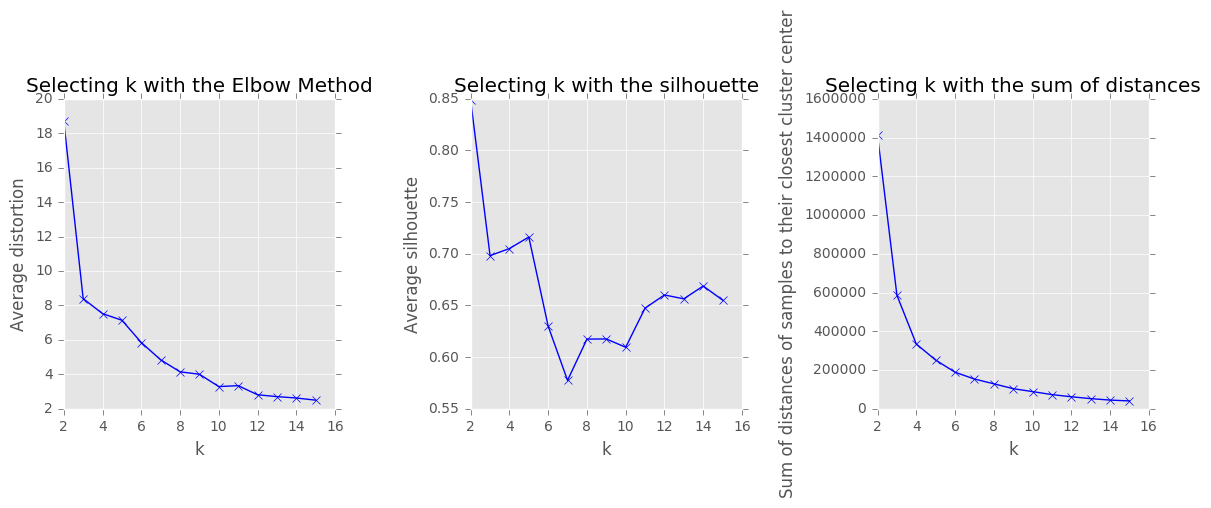

In [6]:
plt.figure(figsize=(14,4))
plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.subplot(131)
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.grid(True)

plt.subplot(132)
plt.plot(K, silhouette_avg, 'bx-')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Selecting k with the silhouette')
plt.grid(True)

plt.subplot(133)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of distances of samples to their closest cluster center')
plt.title('Selecting k with the sum of distances')
plt.grid(True)

plt.show()

## defining optimal number of clusters using scipy

In [7]:
from scipy.cluster.vq import kmeans,vq
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
avgWithinSS1 = [var for (cent,var) in KM] # mean within-cluster sum of squares

D_k = [distance.cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS2 = [sum(d)/X.shape[0] for d in dist]

Z = [vq(X,cent) for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
avgWithinSS3 = [sum(dist)/X.shape[0] for (cIdx,dist) in Z]

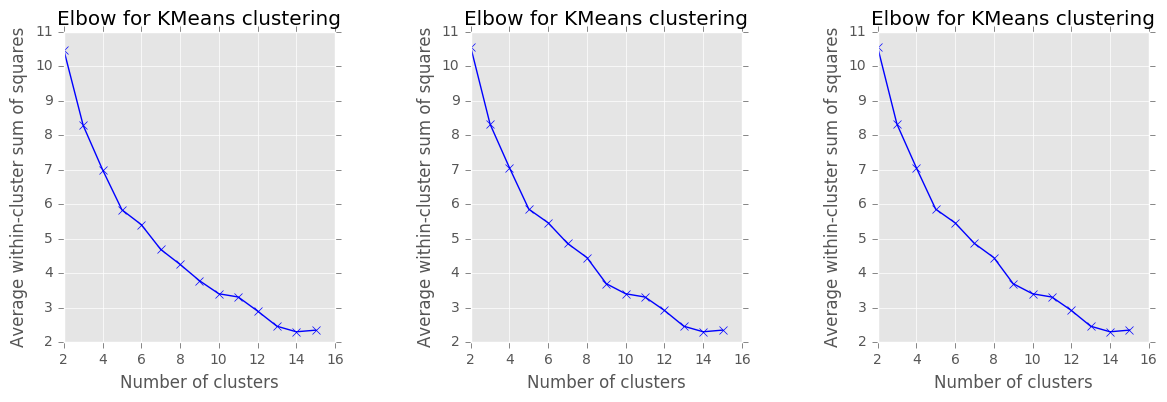

In [8]:
plt.figure(figsize=(14,4))
plt.subplots_adjust(hspace=0.2, wspace=0.5)

plt.subplot(131)
plt.plot(K, avgWithinSS1, 'bx-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

plt.subplot(132)
plt.plot(K, avgWithinSS2, 'bx-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

plt.subplot(133)
plt.plot(K, avgWithinSS3, 'bx-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

plt.show()

## another approach

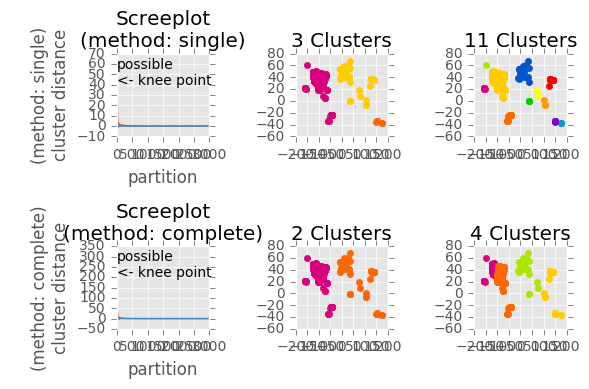

In [9]:
import numpy as np
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt


a = np.array([[0.1,   2.5],
              [1.5,   .4 ],
              [0.3,   1  ],
              [1  ,   .8 ],
              [0.5,   0  ],
              [0  ,   0.5],
              [0.5,   0.5],
              [2.7,   2  ],
              [2.2,   3.1],
              [3  ,   2  ],
              [3.2,   1.3]])
a = X
fig, axes23 = plt.subplots(2, 3)

for method, axes in zip(['single', 'complete'], axes23):
    z = hac.linkage(a, method=method)

    # Plotting
    axes[0].plot(range(1, len(z)+1), z[::-1, 2])
    knee = np.diff(z[::-1, 2], 2)
    axes[0].plot(range(2, len(z)), knee)

    num_clust1 = knee.argmax() + 2
    knee[knee.argmax()] = 0
    num_clust2 = knee.argmax() + 2

    axes[0].text(num_clust1, z[::-1, 2][num_clust1-1], 'possible\n<- knee point')

    part1 = hac.fcluster(z, num_clust1, 'maxclust')
    part2 = hac.fcluster(z, num_clust2, 'maxclust')

    clr = ['#2200CC' ,'#D9007E' ,'#FF6600' ,'#FFCC00' ,'#ACE600' ,'#0099CC' ,
    '#8900CC' ,'#FF0000' ,'#FF9900' ,'#FFFF00' ,'#00CC01' ,'#0055CC']

    for part, ax in zip([part1, part2], axes[1:]):
        for cluster in set(part):
            ax.scatter(a[part == cluster, 0], a[part == cluster, 1], 
                       color=clr[cluster])

    m = '\n(method: {})'.format(method)
    plt.setp(axes[0], title='Screeplot{}'.format(m), xlabel='partition',
             ylabel='{}\ncluster distance'.format(m))
    plt.setp(axes[1], title='{} Clusters'.format(num_clust1))
    plt.setp(axes[2], title='{} Clusters'.format(num_clust2))

plt.tight_layout()
plt.show()